In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

In [2]:
end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)
stock = '^NSEI'  # Replace with your desired stock symbol

data = yf.download(stock, start, end)
data.reset_index(inplace=True)
data.tail()

/tmp/ipython-input-615859279.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, start, end)
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI
4444,2025-10-30,25877.849609,26032.050781,25845.250000,25984.400391,257400
4445,2025-10-31,25722.099609,25953.750000,25711.199219,25863.800781,334400
4446,2025-11-03,25763.349609,25803.099609,25645.500000,25696.849609,23300
4447,2025-11-04,25597.650391,25787.400391,25578.400391,25744.750000,305100
4448,2025-11-06,25509.699219,25679.150391,25491.550781,25593.349609,0


In [3]:
num_zero_rows = 600  # Change if needed
zero_rows = pd.DataFrame(np.nan, index=range(num_zero_rows), columns=data.columns)
data = pd.concat([data, zero_rows], ignore_index=True)
print(data.shape)

(5049, 6)


/tmp/ipython-input-557676546.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, zero_rows], ignore_index=True)


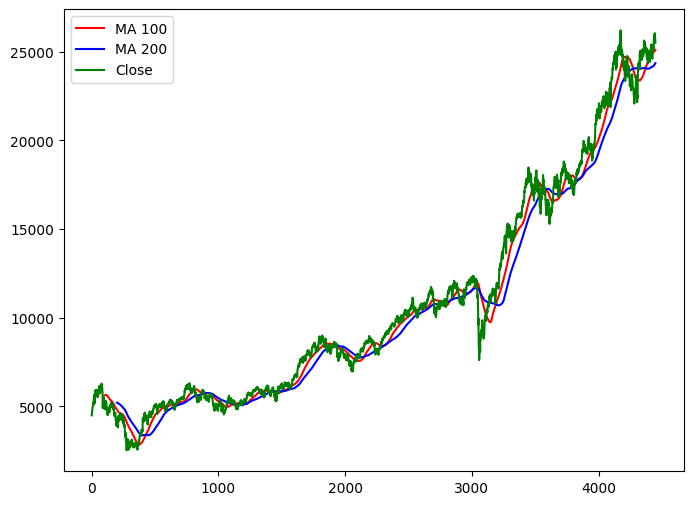

In [4]:
ma_100_days = data['Close'].rolling(100).mean()
ma_200_days = data['Close'].rolling(200).mean()

plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r', label='MA 100')
plt.plot(ma_200_days, 'b', label='MA 200')
plt.plot(data['Close'], 'g', label='Close')
plt.legend()
plt.show()


In [5]:
def calculate_rsi(df, period=14, price_col='Close'):
    delta = df[price_col].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df = data.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df['RSI'] = calculate_rsi(df)

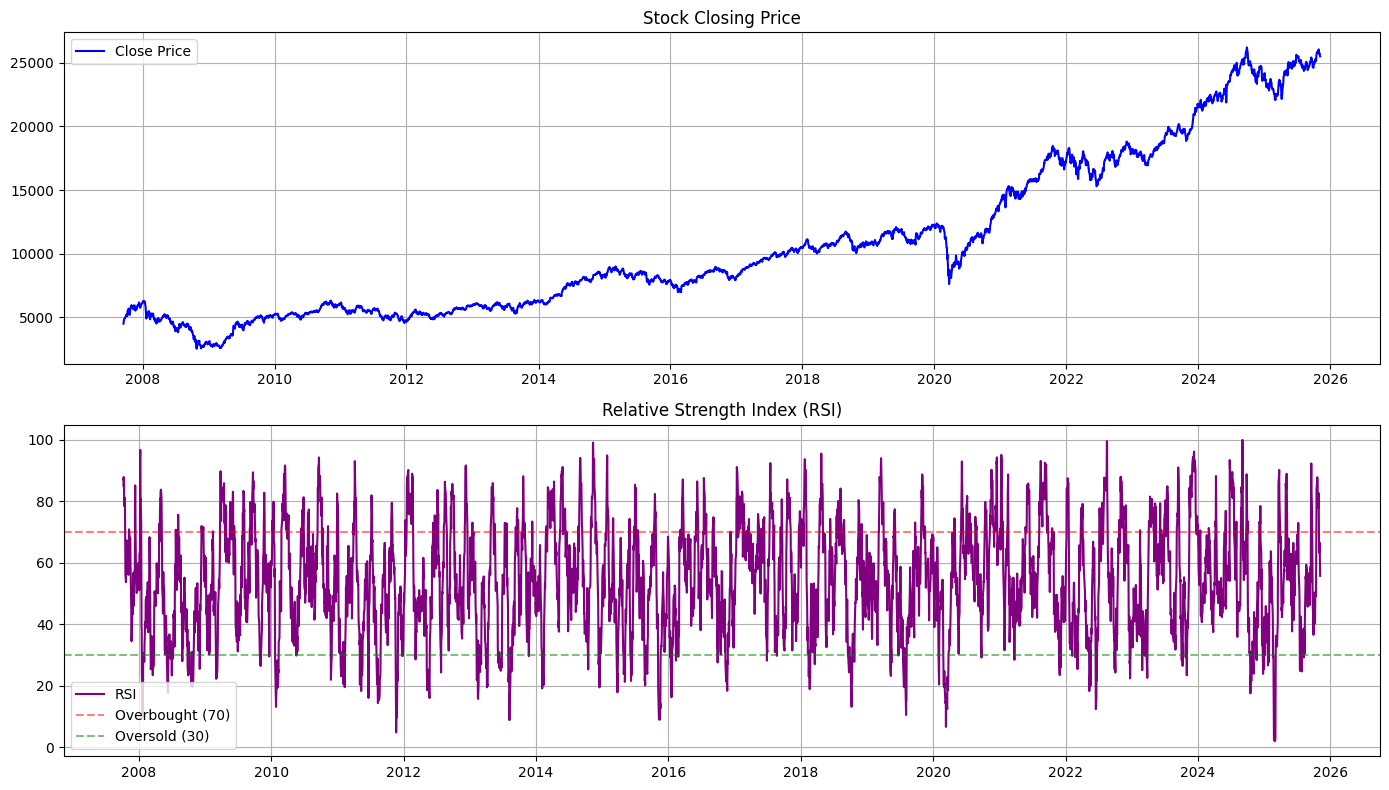

In [6]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('Stock Closing Price')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(df['Date'], df['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', alpha=0.5, color='red', label='Overbought (70)')
plt.axhline(30, linestyle='--', alpha=0.5, color='green', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
data.dropna(inplace=True)

data_train = pd.DataFrame(data['Close'][0: int(len(data) * 0.80)])
data_test = pd.DataFrame(data['Close'][int(len(data) * 0.80):])

print(data_train.shape[0])
print(data_test.shape[0])

3559
890


In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)

x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])

x, y = np.array(x), np.array(y)

In [9]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(120, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x, y, epochs=25, batch_size=32, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - loss: 0.0389
Epoch 2/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0054
Epoch 3/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0045
Epoch 4/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0041
Epoch 5/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0035
Epoch 6/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0052
Epoch 7/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0032
Epoch 8/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0027
Epoch 9/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0029
Epoch 10/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0025
Epoch 11/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0030
Epoch 12/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0025
Epoch 13/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0024
Epoch 14/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0025
Epoch 15/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 4

In [10]:
past_100_days = data_train.tail(100)

In [11]:
data_test = pd.concat([past_100_days, data_test], ignore_index=True)

In [12]:
data_test_scale = scaler.transform(data_test)

In [13]:
x_test = []
y_test = []

for i in range(100, data_test_scale.shape[0]):
    x_test.append(data_test_scale[i-100:i])
    y_test.append(data_test_scale[i, 0])

In [14]:
x_test, y_test = np.array(x_test), np.array(y_test)
y_pred = model.predict(x_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step


In [15]:
scale_factor = 1 / scaler.scale_
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor

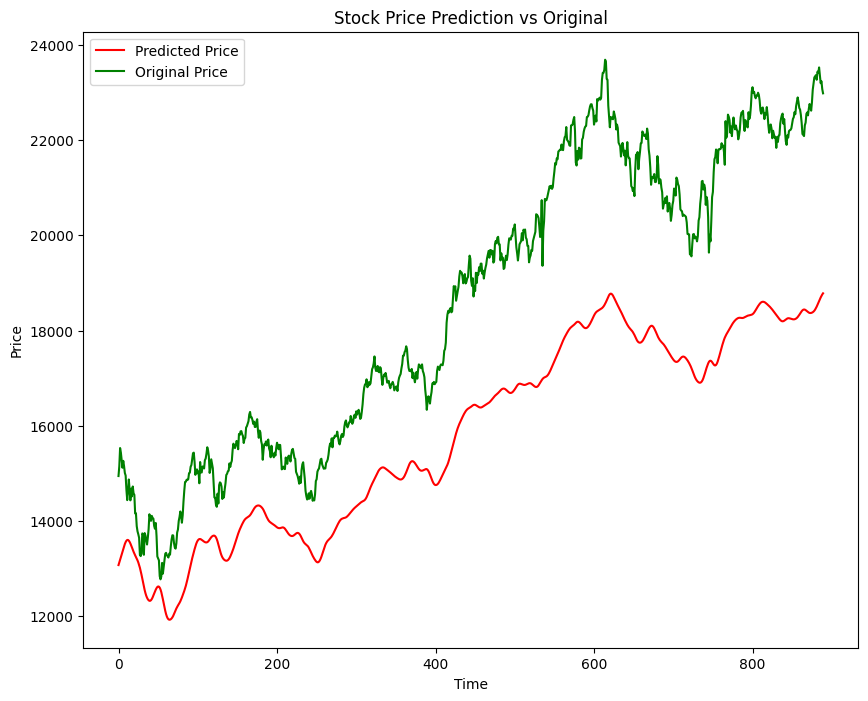

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(y_pred, 'r', label='Predicted Price')
plt.plot(y_test, 'g', label='Original Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title("Stock Price Prediction vs Original")
plt.legend()
plt.show()

In [17]:
future_days = 30  # Days to predict into the future

last_100_scaled = data_train_scale[-100:]
pred_input = list(last_100_scaled.reshape(100))
future_predicted = []

for _ in range(future_days):
    x_input = np.array(pred_input[-100:]).reshape(1, 100, 1)
    pred = model.predict(x_input, verbose=0)
    future_predicted.append(pred[0, 0])
    pred_input.append(pred[0, 0])

future_predicted = np.array(future_predicted).reshape(-1, 1)
future_predicted = future_predicted * scale_factor

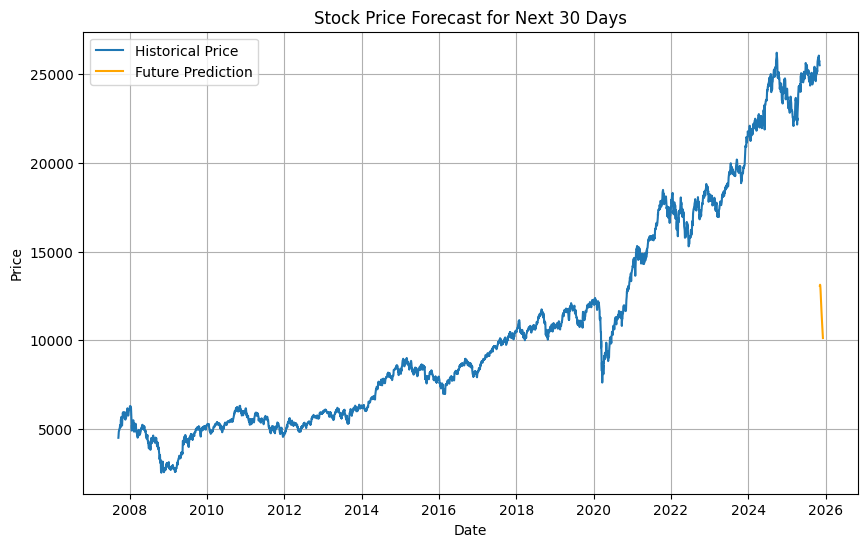

In [18]:
future_dates = pd.date_range(start=end + timedelta(days=1), periods=future_days)

plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Close'], label='Historical Price')
plt.plot(future_dates, future_predicted, label='Future Prediction', color='orange')
plt.title('Stock Price Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
model.save('Stock_Prediction_Future_Model2.keras')

#END